# Efficient Net

Chest Data

In [30]:
from __future__ import print_function

import glob
import os
import random
import cv2
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from tqdm.notebook import tqdm

from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [31]:
# Training settings
epochs = 100
lr = 0.001

In [32]:
#device = 'cuda'
device = 'cpu'

train_dataset_dir = Path('./data/Gender01/train')
val_dataset_dir = Path('./data/Gender01/validation')
test_dataset_dir = Path('./data/Gender01/test')

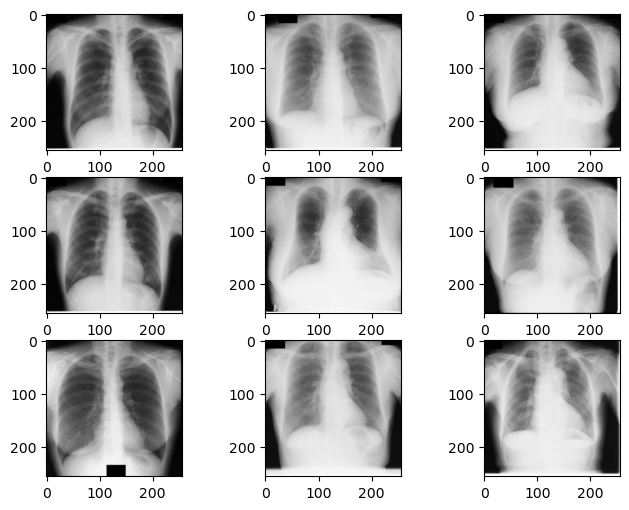

In [33]:
files = glob.glob('./data/Gender01/*/*/*.png')
random_idx = np.random.randint(1, len(files), size=9)
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(files[idx])
    ax.imshow(img, cmap='gray')

In [34]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [35]:
train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)
test_data = datasets.ImageFolder(test_dataset_dir, test_transforms)

In [36]:
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size=16, shuffle=False)

In [37]:
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [38]:
model = timm.create_model('tf_efficientnetv2_s_in21ft1k', pretrained=True, num_classes=2)
model = model.to(device)

In [39]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [40]:
best_loss = None

# Accuracy計算用の関数
def calculate_accuracy(output, target):
    output = (torch.sigmoid(output) >= 0.5)
    target = (target == 1.0)
    accuracy = torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
    return accuracy

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)              

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

    if (best_loss is None) or (best_loss > val_loss):
        best_loss = val_loss
        model_path = './trained_models/bestmodel_efficientnet.pth'
        torch.save(model.state_dict(), model_path)
        
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.7508 - acc: 0.7862 - val_loss : 18.7376 - val_acc: 0.6310




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.5968 - acc: 0.8900 - val_loss : 10.1185 - val_acc: 0.6518




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.2525 - acc: 0.9425 - val_loss : 6.3757 - val_acc: 0.6071




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.3433 - acc: 0.9125 - val_loss : 4.7432 - val_acc: 0.5833




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.2753 - acc: 0.9625 - val_loss : 3.7466 - val_acc: 0.6339




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.1980 - acc: 0.9688 - val_loss : 4.5556 - val_acc: 0.6012




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0198 - acc: 0.9938 - val_loss : 5.0202 - val_acc: 0.5982




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4406 - acc: 0.9125 - val_loss : 5.8214 - val_acc: 0.7024




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0123 - acc: 0.9938 - val_loss : 5.6075 - val_acc: 0.6875




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0395 - acc: 0.9938 - val_loss : 5.7681 - val_acc: 0.6875




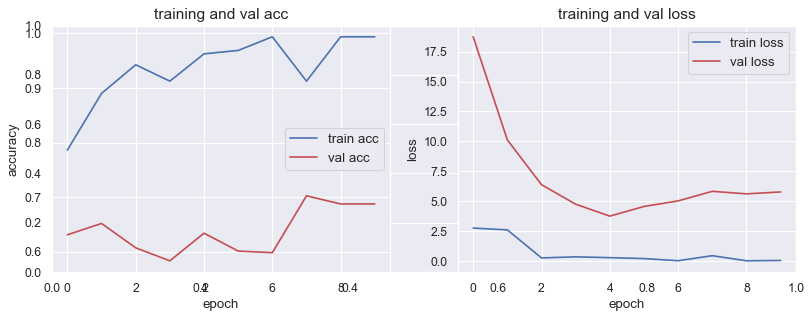

In [41]:
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

C:\Users\tkurita1958\AppData\Local\Temp\ipykernel_5256\1147987467.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./trained_models/best

Accuracy: 0.8723
感度: 0.8846
特異度: 0.8571
PPV: 0.8846
NPV: 0.8571
F-Score: 0.8846
AUC: 0.9304


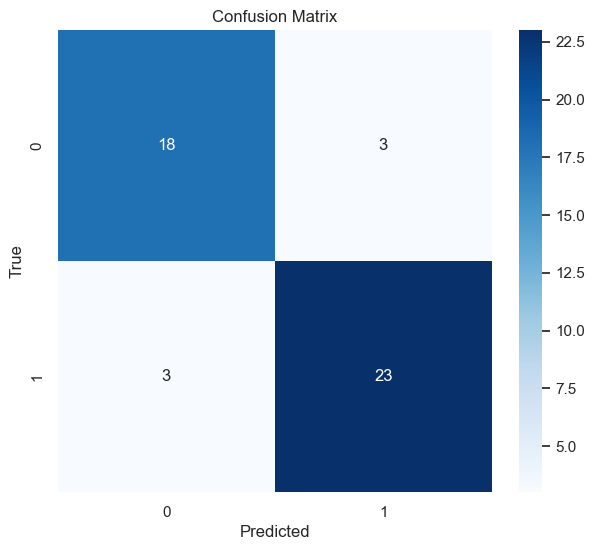

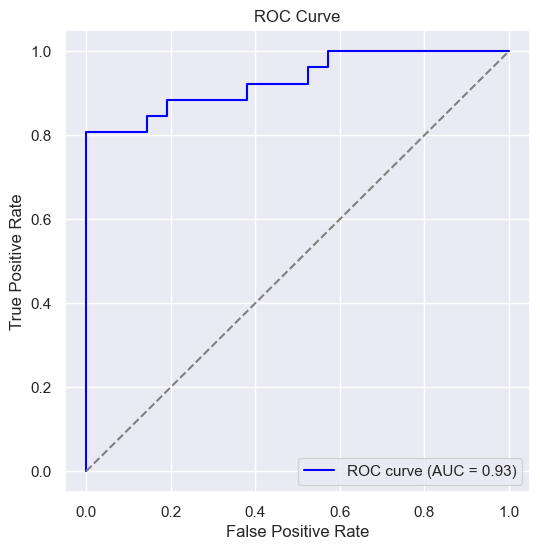

In [42]:
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("./trained_models/bestmodel_efficientnet.pth"))
    model.eval()
    predictions = []
    actuals = []
    probas = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probas.extend(outputs[:, 1].cpu().numpy())  # 二番目のクラス（陽性クラス）の確率
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())


    # 指標の計算
    confusion = confusion_matrix(actuals, predictions)
    accuracy = accuracy_score(actuals, predictions)
    recall = recall_score(actuals, predictions)  # 感度
    specificity = recall_score(actuals, predictions, pos_label=0)
    precision = precision_score(actuals, predictions)  # PPV
    npv = precision_score(actuals, predictions, pos_label=0)  # NPV
    f1 = f1_score(actuals, predictions)
    auc = roc_auc_score(actuals, probas)


    #print("混同行列:\n", confusion)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"感度: {recall:.4f}")
    print(f"特異度: {specificity:.4f}")
    print(f"PPV: {precision:.4f}")
    print(f"NPV: {npv:.4f}")
    print(f"F-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")


    # Confusion matrixの描画
    # 混同行列の可視化
    plt.figure(figsize=(7, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()


    # ROC曲線の描画
    fpr, tpr, thresholds = roc_curve(actuals, probas)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


evaluate_model(model, test_loader)